In [37]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
# plt.rcParams.keys()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
def adjusted_r2(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

df = pd.read_csv('../../datasets/group_14.csv')
df["focus_factor"] = (
    df["focus_factor"]
    .astype(str)                  # ensure it's string
    .str.replace(",", ".", regex=False)  # replace comma with dot
)
df["focus_factor"] = pd.to_numeric(df["focus_factor"], errors="coerce")

In [39]:
# Encode categorical variable
df_encoded = pd.get_dummies(data=df, columns=["target_class"], drop_first=True)

# Define target and features
y = df_encoded['target_regression']
X = df_encoded.drop(columns=["target_regression"])

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1
)

###  Feature Reduction Based on Adjusted R²

This step performs **iterative feature elimination** to simplify the model while maintaining performance.

- A **Linear Regression** model is trained on all features.
- The **Adjusted R²** is calculated as the baseline.
- In each iteration:
  - The algorithm temporarily removes one feature at a time.
  - It retrains the model and recalculates the Adjusted R².
  - The feature whose removal results in the **smallest decrease (or improvement)** in Adjusted R² is permanently dropped.
- The process stops when removing any feature causes the Adjusted R² to drop by more than `0.001`.

This helps identify and remove **redundant or less impactful features**

In [1]:
X_train_reduced = X_train.copy()

n_samples = len(y_train)
lr = LinearRegression()
lr.fit(X_train_reduced, y_train)

prev_adj_r2 = adjusted_r2(y_train, lr.predict(X_train_reduced),
                          n_samples, X_train_reduced.shape[1])

while True:
    improvements = []
    for col in X_train_reduced.columns:
        X_temp = X_train_reduced.drop(columns=[col])
        lr.fit(X_temp, y_train)
        new_adj_r2 = adjusted_r2(y_train, lr.predict(X_temp),
                                 n_samples, X_temp.shape[1])
        improvements.append((col, new_adj_r2 - prev_adj_r2, new_adj_r2))

    best_col, best_improvement, best_new_adj_r2 = max(improvements, key=lambda x: x[1])
    if best_improvement >= -0.001:
        X_train_reduced = X_train_reduced.drop(columns=[best_col])
        prev_adj_r2 = best_new_adj_r2
        print(f"Removed '{best_col}' → adj R² change {best_improvement:+.5f}")
    else:
        print(f"No more removable features")
        break

print(X_train_reduced.columns)

NameError: name 'X_train' is not defined

This step fits a **Linear Regression model** using **statsmodels’ OLS** to analyze feature significance, especially by checking the **p-values** of each feature.
It can be observed that the features selected previously all have **low p-values**, indicating they are statistically significant.


In [41]:
X_train_p = X_train.astype(float)
X_train_sm = sm.add_constant(X_train_p)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      target_regression   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     172.1
Date:                Sun, 12 Oct 2025   Prob (F-statistic):               0.00
Time:                        16:14:36   Log-Likelihood:                -2368.5
No. Observations:                2400   AIC:                             4821.
Df Residuals:                    2358   BIC:                             5064.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
duration_1    

Draw a **correlation matrix** for the selected features to check if any of them are highly correlated.

As observed, there is no high correlation between the features, which is good news because it indicates the model produces more reliable and stable coefficient estimates.

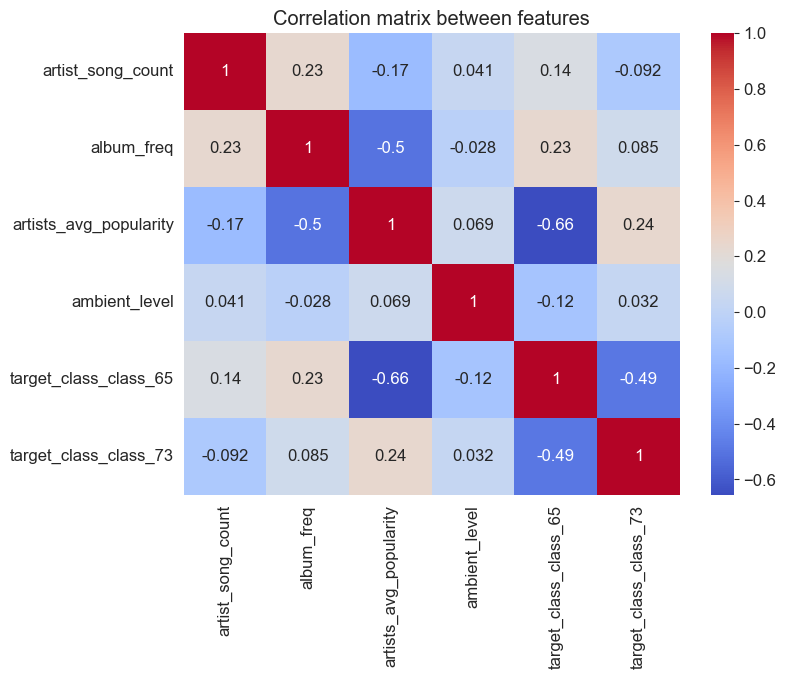

In [42]:
corr_matrix = X_train_reduced.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation matrix between features")
plt.show()

## Model Evaluation with Optimal Features Across 10 Runs

This step evaluates the performance of the **Linear Regression model** using the features selected after feature reduction:
   - The data is split into training and testing sets 10 times with different random seeds.
   - Only the **optimal features** from the previous selection step are used.
   - For each run, the **R² score** and **Mean Squared Error (MSE)** are calculated for training and testing sets.
   - Metrics for all 10 runs are stored in a DataFrame.
   - Side-by-side plots display **R²** and **MSE** across the 10 runs for both training and testing sets.
   - The **mean R²** and **mean MSE** across the 10 runs are computed to summarize overall model performance.



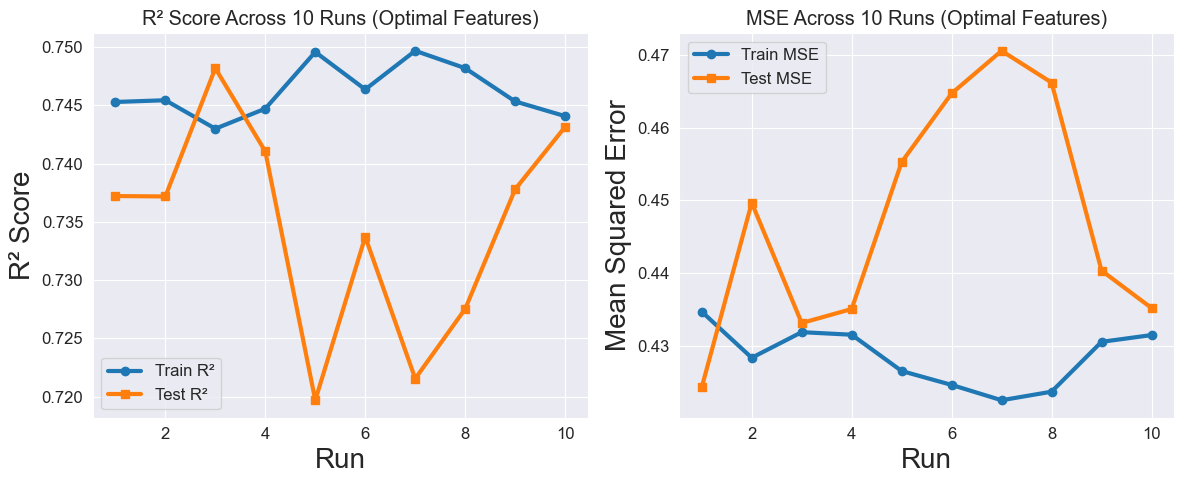

=== Average Metrics Across 10 Runs (Optimal Features) ===
Average Train R²: 0.7462
Average Test  R²: 0.7347
Average Train MSE: 0.4285
Average Test  MSE: 0.4474


In [43]:
all_metrics = []

# Assume optimal_columns is already defined from feature selection
optimal_columns = X_train_reduced.columns.tolist()

# Run 10 iterations with different random splits
for i in range(10):
    # Split the data
    X_train_split, X_test_split, y_train, y_test = train_test_split(
        X[optimal_columns], y, test_size=0.2, random_state=i
    )

    # Fit linear regression on training data
    lr = LinearRegression()
    lr_model = lr.fit(X_train_split, y_train)

    # Predictions
    train_predictions = lr_model.predict(X_train_split)
    test_predictions = lr_model.predict(X_test_split)

    # Compute metrics
    metrics = {
        'Run': i + 1,
        'Train_MSE': mean_squared_error(y_train, train_predictions),
        'Test_MSE': mean_squared_error(y_test, test_predictions),
        'Train_R2': r2_score(y_train, train_predictions),
        'Test_R2': r2_score(y_test, test_predictions)
    }
    all_metrics.append(metrics)

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics)

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot R²
axes[0].plot(metrics_df['Run'], metrics_df['Train_R2'], marker='o', label='Train R²')
axes[0].plot(metrics_df['Run'], metrics_df['Test_R2'], marker='s', label='Test R²')
axes[0].set_title('R² Score Across 10 Runs (Optimal Features)')
axes[0].set_xlabel('Run')
axes[0].set_ylabel('R² Score')
axes[0].legend()
axes[0].grid(True)

# Plot MSE
axes[1].plot(metrics_df['Run'], metrics_df['Train_MSE'], marker='o', label='Train MSE')
axes[1].plot(metrics_df['Run'], metrics_df['Test_MSE'], marker='s', label='Test MSE')
axes[1].set_title('MSE Across 10 Runs (Optimal Features)')
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Mean Squared Error')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# --- Compute averages ---
avg_train_mse = metrics_df['Train_MSE'].mean()
avg_test_mse = metrics_df['Test_MSE'].mean()
avg_train_r2 = metrics_df['Train_R2'].mean()
avg_test_r2 = metrics_df['Test_R2'].mean()

# Print averages
print("=== Average Metrics Across 10 Runs (Optimal Features) ===")
print(f"Average Train R²: {avg_train_r2:.4f}")
print(f"Average Test  R²: {avg_test_r2:.4f}")
print(f"Average Train MSE: {avg_train_mse:.4f}")
print(f"Average Test  MSE: {avg_test_mse:.4f}")

# Feature Selection Analysis

## Overview
We started with a linear regression model using **50 features** and evaluated its performance using **10 random train-test splits**. After performing **backward feature elimination**, we reduced the feature set to the **6 most important predictors** and compared performance metrics.

---

## Performance Comparison

| Model | Train R² | Test R² | Train MSE | Test MSE |
|-------|----------|---------|-----------|----------|
| Original (50 features) | 0.7496 | 0.7304 | 0.4227 | 0.4546 |
| Reduced (6 features)  | 0.7462 | 0.7347 | 0.4285 | 0.4474 |

   - The reduced 6-feature model achieves **almost the same or slightly better predictive accuracy** than the full model.
   - Using fewer features makes the model **more interpretable, faster to train, and less prone to overfitting**.

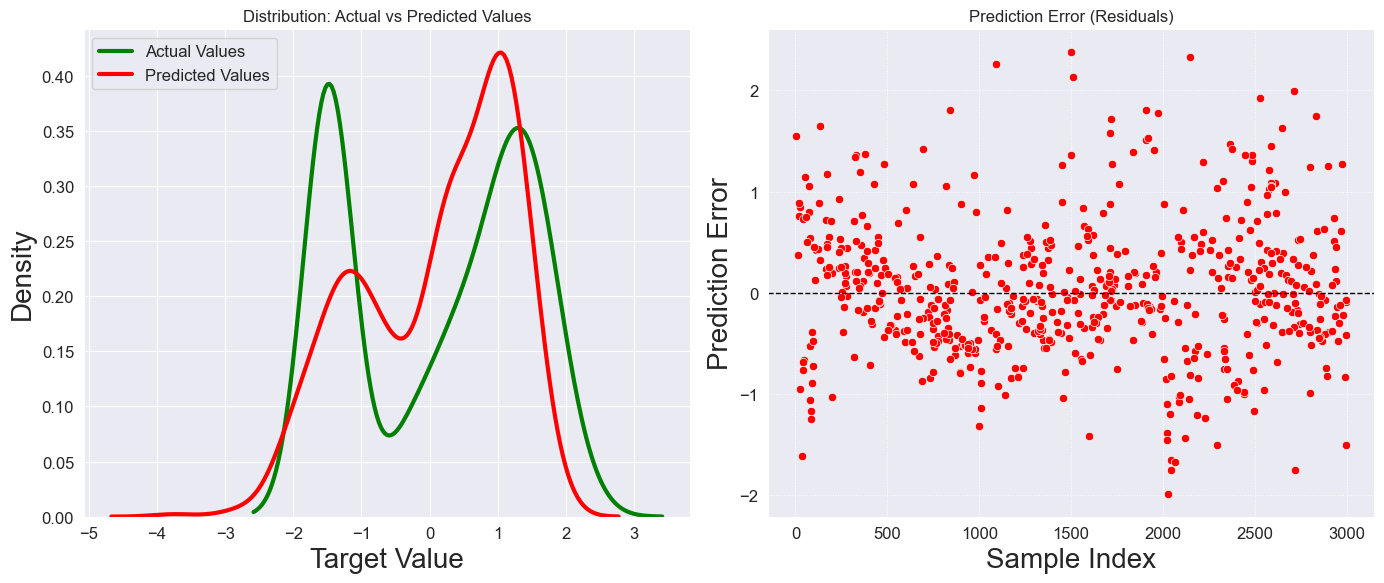

In [44]:
#Perform a test run on an unused random seed
# to evaluate the model's overall performance on unseen data.

X_train, X_test, y_train, y_test = train_test_split(
        X[optimal_columns], y, test_size=0.2, random_state=11
    )
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

predictions = lr_model.predict(X_test)
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'pr_result': predictions,
    'pr_error': y_test - predictions
})

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- (1) Distribution plot: Actual vs Predicted ---
sns.kdeplot(y_test, color="g", label="Actual Values", ax=axes[0])
sns.kdeplot(df_plot['pr_result'], color="r", label="Predicted Values", ax=axes[0])
axes[0].set_title("Distribution: Actual vs Predicted Values", fontsize=12)
axes[0].legend()
axes[0].set_xlabel("Target Value")
axes[0].set_ylabel("Density")

# --- (2) Prediction error (residuals) scatter plot ---
sns.scatterplot(x=df_plot.index, y='pr_error', data=df_plot, color="r", ax=axes[1])
axes[1].set_title("Prediction Error (Residuals)", fontsize=12)
axes[1].set_ylabel("Prediction Error")
axes[1].set_xlabel("Sample Index")
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)  # reference line at 0
axes[1].grid(True, linestyle=':', linewidth=0.7)

plt.tight_layout()
plt.show()